In [ ]:
%pip install tqdm
%pip install wandb --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 11.5 MB/s eta 0:00:00


In [ ]:
import wandb
import os
import torch
from PIL import Image
from torchvision import transforms
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import torchvision.datasets as datasets
from scipy.stats import gaussian_kde
from scipy.stats import norm
from random import randint
import torch.distributions as dist
import math

In [ ]:
wandb.login(key=)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name':'loss',
    'goal':'minimize'
}
sweep_config['metric']=metric

parameters_dict = {
    'latent_dim': {
        'value':10},
    'num_epochs':{
        'value':20},
    'batch_size':{
        'value':16},
    'learning_rate':{
        'value':3.5e-4},
    }

sweep_config['parameters'] = parameters_dict

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='self adapting SBX 7 layer')
project='self adapting SBX 7 layer'
folder_path=f"/content/drive/MyDrive/Colab Notebooks/FYP/Sweeps/{project}/{sweep_id}"
os.makedirs(folder_path)

Create sweep with ID: 0nej4dk0
Sweep URL: https://wandb.ai/t-a-emm-20/self%20adapting%20SBX%207%20layer/sweeps/0nej4dk0


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17911624.82it/s]


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 481865.53it/s]


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4456586.52it/s]


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5419780.59it/s]


Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw

torch.Size([50000, 1, 28, 28])


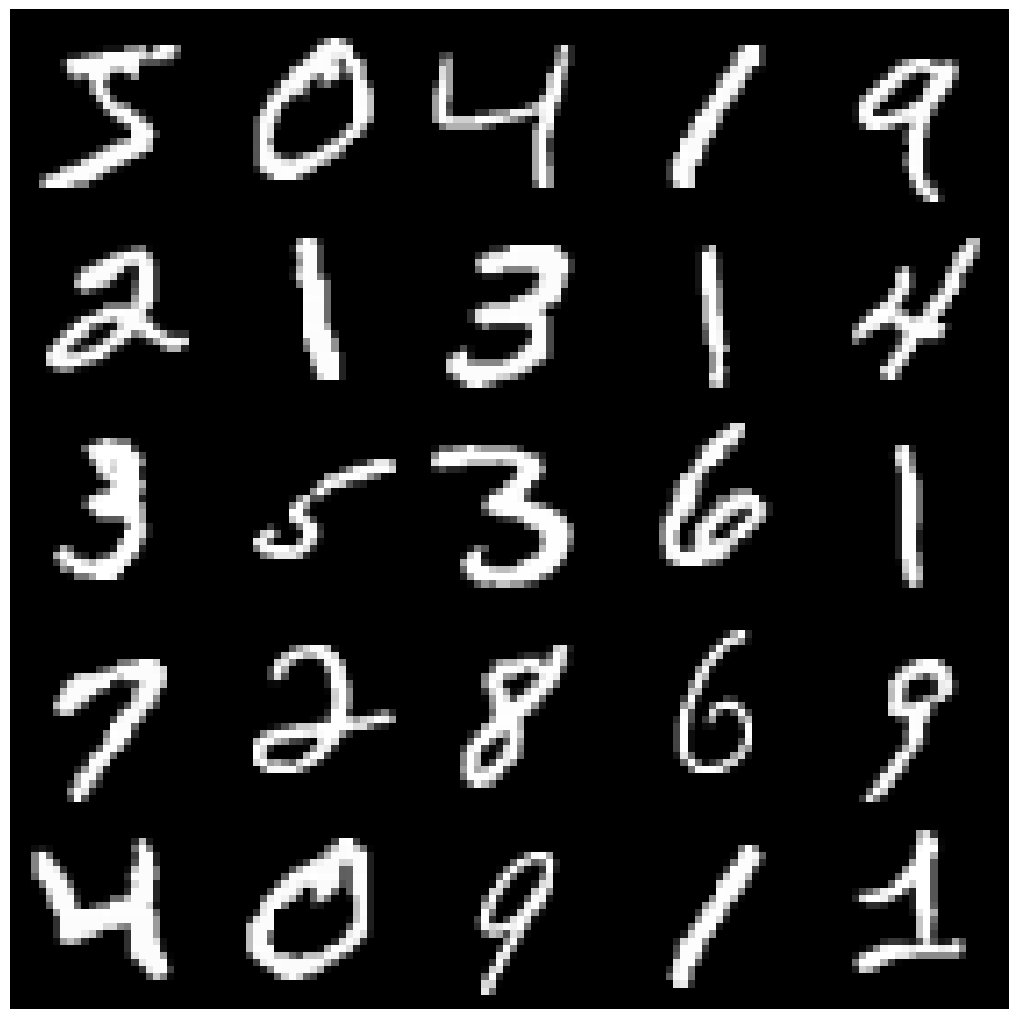

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=None)

train_dataset = mnist_trainset.data[:-10000].reshape(-1, 1, 28, 28) / 255.
eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(train_dataset[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

print(train_dataset.shape)

In [ ]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
      super().__init__()
      #encoding
      self.in_lay=nn.Linear(input_dim,1600)
      self.enclay1=nn.Linear(1600,800)
      self.mu=nn.Linear(800,latent_dim)
      self.logstd=nn.Linear(800,latent_dim)

      #deocoding
      self.declay1=nn.Linear(latent_dim,800)
      self.declay2=nn.Linear(800,1600)
      self.out_lay=nn.Linear(1600,input_dim)

      self.relu=nn.ReLU()

    def encode(self,x):
        el1=self.relu(self.in_lay(x))
        el2=self.relu(self.enclay1(el1))
        mu=self.mu(el2)
        logstd=self.logstd(el2)

        return mu, logstd

    def decode(self, z):
        dl1=self.relu(self.declay1(z))
        dl2=self.relu(self.declay2(dl1))

        return torch.sigmoid(self.out_lay(dl2))

    def forward(self,x):
        mu, logstd = self.encode(x)
        std=torch.exp(logstd)
        eps = torch.randn_like(logstd)
        z_reparam = mu + std*eps
        z_prior = torch.randn_like(logstd)
        x_recon = self.decode(z_reparam)

        return x_recon, mu, logstd, z_prior, z_reparam

In [ ]:
def loss_function(x, x_recon, mu, logstd, n, latent_dim, kernel_bandwidth, scales, z_reparam, z_prior):
    recon_loss=F.mse_loss(x_recon.reshape(x.shape[0],-1),x.reshape(x.shape[0],-1),reduction='sum')
    kl_div = -0.5*torch.sum(1+logstd-mu.pow(2)-(torch.exp(logstd)).pow(2))

    def imq_kernel(z1,z2):
        Cbase = (2* latent_dim * kernel_bandwidth**2)
        k =0
        for scale in scales:
            C=scale*Cbase

            k+= C/(C + torch.norm(z1.unsqueeze(1)-z2.unsqueeze(0),dim=-1) ** 2)
        return k

    k_z=imq_kernel(z_reparam,z_reparam)
    k_z_prior=imq_kernel(z_prior,z_prior)
    k_cross=imq_kernel(z_reparam,z_prior)

    mmd_z=(k_z - k_z.diag().diag()).sum()/((n-1)*n)
    mmd_z_prior=(k_z_prior-k_z_prior.diag().diag()).sum()/((n-1)*n)
    mmd_cross=k_cross.sum()/(n**2)
    mmd_loss=mmd_z+mmd_z_prior-2*mmd_cross

    return recon_loss, kl_div, mmd_loss

In [ ]:
def fitness_func(alpha, lbd, recon_loss, kl_div, mmd_loss, loss):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    loss_new = recon_loss + (1-alpha)*kl_div + (alpha + lbd -1)*mmd_loss
    fitness=1/loss_new

    return fitness.to(device)

In [ ]:
def det_func(alpha, lbd, recon_loss, kl_div, mmd_loss):
    loss_new= recon_loss + (1-alpha)*kl_div + (alpha + lbd - 1)*mmd_loss
    det = 1/ loss_new

    return det

In [ ]:
def selfadapt_SBX(pop_size, mutation_rate, eta_alpha, eta_lbd, crossover_rate, alpha_tprev, lbd_tprev, recon_loss, kl_div, mmd_loss, loss):
    pop=[(dist.Normal(alpha_tprev,0.03).sample(), dist.Normal(lbd_tprev,2).sample()) for n in range(pop_size)]
    fit_scores=[fitness_func(alpha_t,lbd_t, recon_loss, kl_div, mmd_loss, loss) for alpha_t, lbd_t in pop]
    sorted_ind=sorted(range(len(fit_scores)), key=lambda i: fit_scores[i], reverse=True)
    sorted_pop=[pop[i] for i in sorted_ind]
    fit_probs=torch.softmax(torch.tensor(fit_scores), dim=0)
    new_pop=[]

    for i in range(pop_size):
        prt=torch.rand(1)
        parent1 = torch.multinomial(fit_probs.clone().detach(),1, replacement=False)
        alpha_t1, lbd_t1=sorted_pop[parent1]
        #alpha_t2, lbd_t2=sorted_pop[parent2]

        if prt<crossover_rate:
            u=torch.rand(1).to(device)
            if u <= 0.5:
                rcalpha=(2*u)**(1/(eta_alpha + 1))
                rclbd=(2*u)**(1/(eta_lbd + 1))
            else:
                rcalpha=(1/(2*(1-u)))**(1/(eta_alpha + 1))
                rclbd=(1/(2*(1-u)))**(1/(eta_lbd + 1))
            cpop=[]
            alpha1=0.5*((1 + rcalpha)*alpha_t1 + (1 - rcalpha)*alpha_tprev)
            lbd1=0.5*((1 + rclbd)*lbd_t1 + (1 - rclbd)*lbd_tprev)
            cpop.append((alpha1,lbd1))

            alpha2=0.5*((1 - rcalpha)*alpha_t1 + (1 + rcalpha)*alpha_tprev)
            lbd2=0.5*((1 - rclbd)*lbd_t1 + (1 + rclbd)*lbd_tprev)
            cpop.append((alpha2,lbd2))

            cfit_scores=[fitness_func(alpha_tplus1, lbd_tplus1, recon_loss, kl_div, mmd_loss, loss) for alpha_tplus1, lbd_tplus1 in cpop]
            sorted_scores= sorted(range(len(cfit_scores)), key=lambda i: cfit_scores[i], reverse=True)
            sorted_cpop=[cpop[i] for i in sorted_scores]

            alpha_tplus1, lbd_tplus1 = sorted_cpop[0]

            gamma_alpha = 1.1
            beta_alpha=abs(1 + 2*((alpha_tplus1-alpha_tprev)/(alpha_tprev-alpha_t1)))
            gamma_lbd = 1.5
            beta_lbd=abs(1 + 2*((lbd_tplus1-lbd_tprev)/(lbd_tprev-lbd_t1)))

            parent1_fit=fitness_func(alpha_t1, lbd_t1, recon_loss, kl_div, mmd_loss, loss)
            parent2_fit=fitness_func(alpha_tprev, lbd_tprev, recon_loss, kl_div, mmd_loss, loss)
            child_fit=fitness_func(alpha_tplus1, lbd_tplus1, recon_loss, kl_div, mmd_loss, loss)

            if alpha_t1 > alpha_tprev:
                if alpha_tplus1 < alpha_tprev:
                    if child_fit > parent2_fit:
                        eta_alpha_dash = -1 + ((eta_alpha + 1)*math.log(beta_alpha))/(math.log(1 + gamma_alpha*(beta_alpha - 1)))
                    else:
                        eta_alpha_dash = -1 + ((eta_alpha + 1)*math.log(beta_alpha))/(math.log(1 + (1/gamma_alpha)*(beta_alpha -1)))

                elif alpha_tplus1 > alpha_t1:
                    if child_fit > parent1_fit:
                        eta_alpha_dash= -1 + ((eta_alpha + 1)*math.log(beta_alpha))/(math.log(1 + gamma_alpha*(beta_alpha - 1)))
                    else:
                        eta_alpha_dash = -1 + ((eta_alpha + 1)*math.log(beta_alpha))/(math.log(1 + (1/gamma_alpha)*(beta_alpha -1)))

                else:
                    if child_fit > parent1_fit or child_fit > parent2_fit:
                        eta_alpha_dash= ((1 + eta_alpha)/gamma_alpha)-1
                    else:
                        eta_alpha_dash= gamma_alpha*(1 + eta_alpha)-1

            else:
                if alpha_tplus1 < alpha_t1:
                    if child_fit > parent1_fit:
                        eta_alpha_dash= -1 + ((eta_alpha + 1)*math.log(beta_alpha))/(math.log(1 + gamma_alpha*(beta_alpha - 1)))
                    else:
                        eta_alpha_dash = -1 + ((eta_alpha + 1)*math.log(beta_alpha))/(math.log(1 + (1/gamma_alpha)*(beta_alpha -1)))

                elif alpha_tplus1 > alpha_tprev:
                      if child_fit > parent2_fit:
                          eta_alpha_dash= -1 + ((eta_alpha + 1)*math.log(beta_alpha))/(math.log(1 + gamma_alpha*(beta_alpha - 1)))
                      else:
                          eta_alpha_dash = -1 + ((eta_alpha + 1)*math.log(beta_alpha))/(math.log(1 + (1/gamma_alpha)*(beta_alpha -1)))

                else:
                    if child_fit > parent1_fit or child_fit > parent2_fit:
                        eta_alpha_dash= ((1 + eta_alpha)/gamma_alpha) - 1
                    else:
                        eta_alpha_dash= gamma_alpha*(1 + eta_alpha) - 1

            if lbd_t1 > lbd_tprev:
                if lbd_tplus1 < lbd_tprev:
                    if child_fit > parent2_fit:
                        eta_lbd_dash= -1 + ((eta_lbd + 1)*math.log(beta_lbd))/(math.log(1 + gamma_lbd*(beta_lbd - 1)))
                    else:
                        eta_lbd_dash= -1 + ((eta_lbd + 1)*math.log(beta_lbd))/(math.log(1 + (1/gamma_lbd)*(beta_lbd - 1)))

                elif lbd_tplus1 > lbd_t1:
                    if child_fit > parent1_fit:
                        eta_lbd_dash= -1 + ((eta_lbd + 1)*math.log(beta_lbd))/(math.log(1 + gamma_lbd*(beta_lbd - 1)))
                    else:
                        eta_lbd_dash= -1 + ((eta_lbd + 1)*math.log(beta_lbd))/(math.log(1 + (1/gamma_lbd)*(beta_lbd - 1)))

                else:
                    if child_fit > parent1_fit or child_fit > parent2_fit:
                        eta_lbd_dash= ((1 + eta_lbd)/gamma_lbd) - 1
                    else:
                        eta_lbd_dash= gamma_lbd*(1 + eta_lbd) - 1

            else:
                if lbd_tplus1 < lbd_t1:
                    if child_fit > parent1_fit:
                        eta_lbd_dash= -1 + ((eta_lbd + 1)*math.log(beta_lbd))/(math.log(1 + gamma_lbd*(beta_lbd - 1)))
                    else:
                        eta_lbd_dash = -1 + ((eta_lbd + 1)*math.log(beta_lbd))/(math.log(1 + (1/gamma_lbd)*(beta_lbd -1)))

                elif lbd_tplus1 > lbd_tprev:
                    if child_fit > parent2_fit:
                        eta_lbd_dash= -1 + ((eta_lbd + 1)*math.log(beta_lbd))/(math.log(1 + gamma_lbd*(beta_lbd - 1)))
                    else:
                        eta_lbd_dash= -1 + ((eta_lbd + 1)*math.log(beta_lbd))/(math.log(1 + (1/gamma_lbd)*(beta_lbd - 1)))

                else:
                    if child_fit > parent1_fit or child_fit > parent2_fit:
                        eta_lbd_dash = ((1 + eta_lbd)/gamma_lbd) - 1
                    else:
                        eta_lbd_dash = gamma_lbd*(1 + eta_lbd) - 1

            if eta_alpha_dash < 0:
                eta_alpha_dash=0

            if eta_alpha_dash > 50:
                eta_alpha_dash = 50

            if eta_lbd_dash < 0:
                eta_lbd_dash = 0

            if eta_lbd_dash > 50:
                eta_alpha_dash = 50

            if prt<mutation_rate:
                m=torch.tensor(random.uniform(-4,4)).to(device)
                rm=(1/6)*((1/math.pi)*(1/(1+m**2)))
                alpha_tplus1= alpha_tplus1 + rm
                l=torch.tensor(random.uniform(-4,4)).to(device)
                rm=((1/math.pi)*(1/(1+l**2)))
                lbd_tplus1= lbd_tplus1 + rm
                new_pop.append((alpha_tplus1, lbd_tplus1, eta_alpha_dash, eta_lbd_dash))

            else:
                new_pop.append((alpha_tplus1, lbd_tplus1, eta_alpha_dash, eta_lbd_dash))


        elif prt<mutation_rate:
            m=torch.tensor(random.uniform(-4,4)).to(device)
            rm=(1/6)*((1/math.pi)*(1/(1+m**2)))
            alpha_tplus1= alpha_t1 + rm
            l=torch.tensor(random.uniform(-4,4)).to(device)
            rm=((1/math.pi)*(1/(1+l**2)))
            lbd_tplus1= lbd_t1 + rm
            new_pop.append((alpha_tplus1, lbd_tplus1, eta_alpha, eta_lbd))

        else:
            k=torch.randint(0, len(sorted_pop), (1,))
            #k=torch.multinomial(fit_probs.clone().detach(),1, replacement=False)
            alpha_tplus1, lbd_tplus1 = sorted_pop[k]
            new_pop.append((alpha_tplus1, lbd_tplus1, eta_alpha, eta_lbd))


    final_pop=[]
    for i in range(len(new_pop)):
      alpha_tplus1, lbd_tplus1, eta_alpha, eta_lbd = new_pop[i]

      if (1-alpha_tplus1)*kl_div > 0:
          final_pop.append((alpha_tplus1, lbd_tplus1, eta_alpha, eta_lbd))

    post_fit=[fitness_func(alpha_tplus1,lbd_tplus1, recon_loss, kl_div, mmd_loss, loss) for alpha_tplus1, lbd_tplus1, eta_alpha, eta_lbd in final_pop]
    post_fit_probs=torch.softmax(torch.tensor(post_fit), dim=0)
    child = torch.multinomial(post_fit_probs.clone().detach(),1, replacement=False)

    #alpha_star, lbd_star, eta_alpha_dash, eta_lbd_dash=final_pop[child]
    alpha_star, lbd_star, eta_alpha_dash, eta_lbd_dash = max(final_pop, key=lambda ind: fitness_func(ind[0], ind[1], recon_loss, kl_div, mmd_loss, loss))

    return alpha_star, lbd_star, eta_alpha_dash, eta_lbd_dash

In [ ]:
def train(config=None):
    wandb.init(config = config)
    config=wandb.config


    input_dim=784
    latent_dim=config.latent_dim
    num_epochs=config.num_epochs
    batch_size=config.batch_size
    learning_rate=config.learning_rate
    alpha=0.4
    lbd=random.uniform(25,100)
    scales = [0.1, 0.2, 0.5, 1.0, 2.0, 5, 10.0]
    kernel_bandwidth=1

    pop_size=8
    num_gen=2
    eta_alpha=8
    eta_lbd=3
    mutation_rate=0.2
    crossover_rate=0.3

    #dataset
    train_loader=DataLoader(dataset=train_dataset, batch_size=batch_size)
    model=VariationalAutoEncoder(input_dim, latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    z_star=[]

    #train
    for epoch in range(num_epochs):
        loop=tqdm(enumerate(train_loader))

        for i, x in loop:
            x=x.to(device).view(x.shape[0],input_dim)
            x_recon, mu, var, z_prior, z_reparam =model(x)
            n=z_reparam.shape[0]
            z_star.append(z_reparam.detach())

            recon_loss, kl_div, mmd_loss=loss_function(x, x_recon, mu, var, n, latent_dim, kernel_bandwidth, scales, z_reparam, z_prior)

            loss= recon_loss + (1-alpha)*kl_div + (alpha + lbd -1)*mmd_loss

            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())

            wandb.log({'loss':loss,'epoch':epoch,'recon loss':recon_loss,'kl diverg':kl_div,'mmd loss':mmd_loss})

        alpha_star, lbd_star, eta_alpha_dash, eta_lbd_dash= selfadapt_SBX(pop_size, mutation_rate, eta_alpha, eta_lbd, crossover_rate, alpha, lbd, recon_loss, kl_div, mmd_loss, loss)
        #alpha_star, lbd_star, eta_alpha_dash, eta_lbd_dash, beta_alpha, beta_lbd = test_SBX(pop_size, mutation_rate, eta_alpha, eta_lbd, crossover_rate, alpha, lbd, recon_loss, kl_div, mmd_loss, loss)
        alpha=alpha_star
        lbd=lbd_star
        eta_alpha=eta_alpha_dash
        eta_lbd=eta_lbd_dash
        #print(beta_alpha)
        #print(beta_lbd)
        wandb.log({'alpha':alpha, 'lbd':lbd, 'eta_alpha':eta_alpha, 'eta_lbd':eta_lbd})


    #Sample
    gen_imgs=[]
    num_samples=25
    full_batch_nbr=int(num_samples/batch_size)
    last_batch_nbr=num_samples % batch_size

    for i in range(num_samples):
        z_gen=torch.zeros(10)
        for j in range(latent_dim):
            z_gen[j]=torch.tensor(np.random.normal(loc=0, scale=1, size=1))
        #print(z_gen)
        z_gen=z_gen.to(device)
        x_gen=model.decode(z_gen).detach()
        gen_img=x_gen.reshape(1,28,28)
        gen_imgs.append(gen_img)
    gen_imgs=torch.stack(gen_imgs)


    #Plot
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

    for i in range(5):
        for j in range(5):
            axes[i][j].imshow(gen_imgs[i*5 +j].cpu().squeeze(0), cmap='gray')
            axes[i][j].axis('off')
    plt.tight_layout(pad=0.)

    run_name=wandb.run.name
    run_gen='generated'
    run_gen_name=run_name+run_gen
    img_path=f"/content/drive/MyDrive/Colab Notebooks/FYP/Sweeps/{project}/{sweep_id}/{run_gen_name}.png"
    plt.savefig(img_path)


    #Reconstruction
    to_recon=[]
    hi=[1,3,5,7,9,0,18,15,17,4]
    for i in range(10):
        to_recon.append(train_dataset[hi[i]])

    to_recon_imgs=torch.stack(to_recon)

    recond=[]
    rec_errors=[]
    for i in range(10):
        x=to_recon_imgs[i].to(device).view(1,input_dim)
        x_recon, mu, logstd, z_prior, z_reparam =model(x)
        recon_error=F.mse_loss(x_recon.reshape(x.shape[0],-1),x.reshape(x.shape[0],-1),reduction='mean')
        x_recon_img=x_recon.reshape(1,28,28)
        recond.append(x_recon_img.detach())
        rec_errors.append(recon_error.detach())

    recond_imgs=torch.stack(recond)
    print(rec_errors)

    fig3, axes3 = plt.subplots(nrows=2, ncols=10, figsize=(10,2))
    for i in range(10):
        axes3[0][i].imshow(to_recon_imgs[i].cpu().squeeze(0), cmap='gray')
        axes3[0][i].axis('off')
        axes3[1][i].imshow(recond_imgs[i].cpu().squeeze(0), cmap='gray')
        axes3[1][i].axis('off')

    plt.tight_layout(pad=0.)
    run_recon='recon'
    run_recon_name=run_name+run_recon
    img_path=f"/content/drive/MyDrive/Colab Notebooks/FYP/Sweeps/{project}/{sweep_id}/{run_recon_name}.png"
    plt.savefig(img_path)

    #Disentanglment Metric
    fixed_metric=randint(0,9)
    num_tests=15
    zldiff=[]

    for j in range(num_tests):
        v1=torch.zeros(latent_dim)
        v2=torch.zeros(latent_dim)

        for i in range(latent_dim):
            v1[i]=torch.tensor(np.random.normal(loc=0, scale=0.95, size=1))
            v2[i]=torch.tensor(np.random.normal(loc=0, scale=0.95, size=1))
            t=torch.tensor(np.random.normal(loc=0, scale=0.95, size=1))
            v1[fixed_metric]=t
            v2[fixed_metric]=t
            v1=v1.to(device)
            v2=v2.to(device)

        x1=model.decode(v1).detach()
        x1_img=x1.reshape(1,28,28)
        x2=model.decode(v2).detach()
        x2_img=x2.reshape(1,28,28)

        z1mu, z1logstd=model.encode(x1)
        z2mu, z2logstd=model.encode(x2)

        eps1=torch.randn_like(z1logstd)
        #std1=torch.exp(z1logstd)
        z1=z1mu+eps1*torch.exp(0.5*z1logstd)

        eps2=torch.randn_like(z2logstd)
        #std2=torch.exp(z2logstd)
        z2=z2mu+eps2*torch.exp(0.5*z2logstd)

        for i in range(len(z1)):
            zldiff.append(abs(z1[i]-z2[i]))

    zldiff=torch.stack(zldiff)
    zbdiff=(1/(num_tests*latent_dim))*torch.sum(zldiff)*100
    print(zbdiff)
    wandb.log({'zbdiff':zbdiff})

wandb: Agent Starting Run: 93dd2k9o with config:
wandb: 	batch_size: 16
wandb: 	latent_dim: 10
wandb: 	learning_rate: 0.00035
wandb: 	num_epochs: 20


3125it [00:40, 78.05it/s, loss=427]
3125it [00:40, 77.41it/s, loss=384]
3125it [00:40, 77.11it/s, loss=332]
3125it [00:40, 77.28it/s, loss=311]
3125it [00:41, 76.10it/s, loss=293]
3125it [00:40, 76.73it/s, loss=263]
3125it [00:40, 76.99it/s, loss=255]
3125it [00:41, 76.16it/s, loss=241]
3125it [00:40, 76.75it/s, loss=231]
3125it [00:40, 76.54it/s, loss=215]
3125it [00:40, 76.38it/s, loss=212]
3125it [00:40, 76.84it/s, loss=187]
3125it [00:40, 77.27it/s, loss=182]
3125it [00:40, 77.48it/s, loss=159]
3125it [00:40, 76.99it/s, loss=156]
3125it [00:40, 76.47it/s, loss=141]
3125it [00:40, 76.92it/s, loss=151]
3125it [00:40, 76.54it/s, loss=137]
3125it [00:40, 76.27it/s, loss=136]
3125it [00:40, 76.99it/s, loss=144]


[tensor(0.0096, device='cuda:0'), tensor(0.0023, device='cuda:0'), tensor(0.0165, device='cuda:0'), tensor(0.0089, device='cuda:0'), tensor(0.0073, device='cuda:0'), tensor(0.0210, device='cuda:0'), tensor(0.0056, device='cuda:0'), tensor(0.0055, device='cuda:0'), tensor(0.0122, device='cuda:0'), tensor(0.0101, device='cuda:0')]
tensor(96.6276, device='cuda:0', grad_fn=<MulBackward0>)


alpha,▁▂▂▃▄▄▅▅▅▆▇▇████████
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
eta_alpha,█▇▆▅▅▅▅▅▄▃▃▃▂▂▂▂▁▁▁▁
eta_lbd,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kl diverg,▁▂▂▂▂▃▃▃▃▃▃▄▃▃▃▄▄▃▄▄▄▄▄▄▅▅▆▆▇███▆▆▇▇██▆▇
lbd,█▆▇▅▃▂▂▂▂▁▂▃▅▄▄▄▁▁▂▅
loss,█▅▅▅▄▄▅▄▅▄▂▄▃▃▃▃▃▂▃▃▂▂▃▃▂▂▂▂▂▂▁▁▁▁▂▂▂▁▂▂
mmd loss,▃▃▄▄▄▃▃▃█▂▃▄▂▄▄▄▅▄▁▄▂▂▃▂▁▁▃▂▅▃▃▂▂▃▃▂▁▂▃▆
recon loss,█▅▅▄▃▃▄▃▄▃▁▃▂▂▃▂▂▁▂▂▂▂▂▃▂▁▂▂▂▂▁▁▁▁▂▂▂▁▂▁
zbdiff,▁
alpha,0.99294


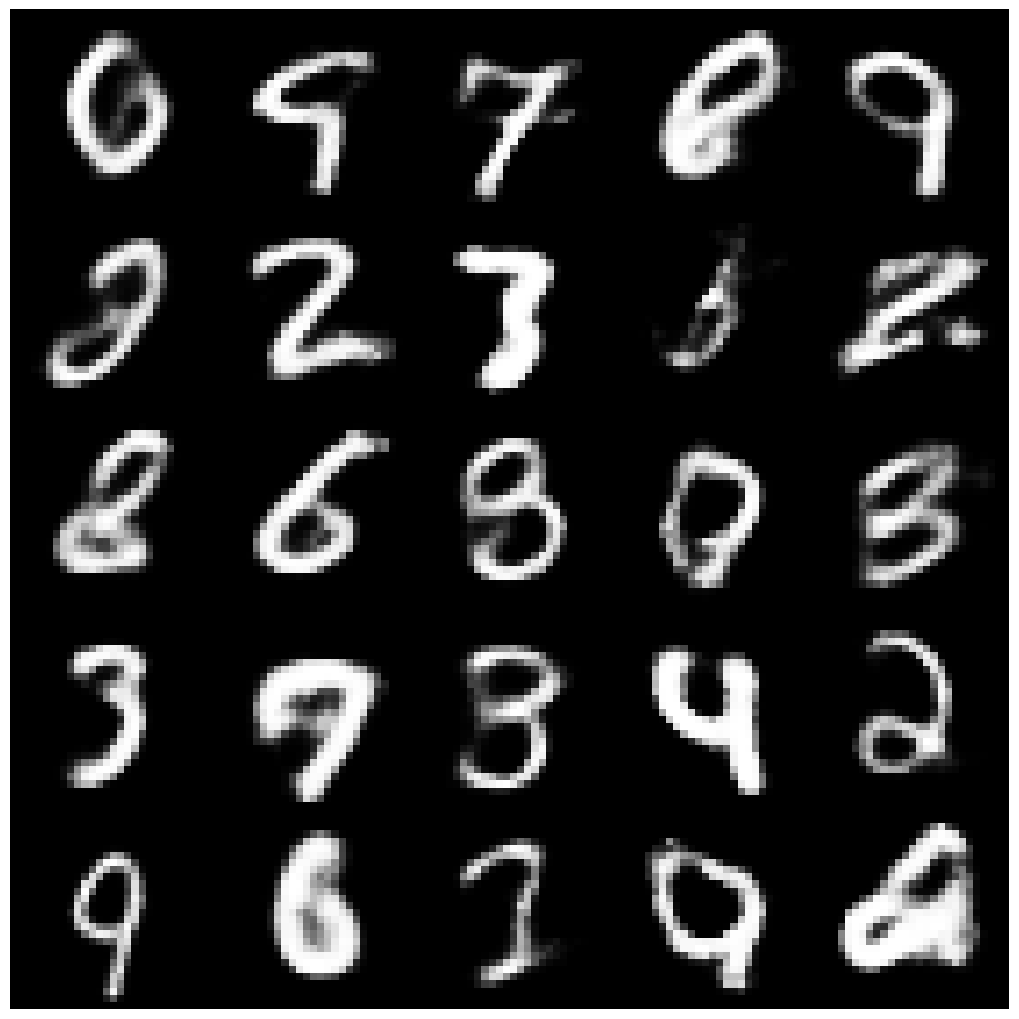

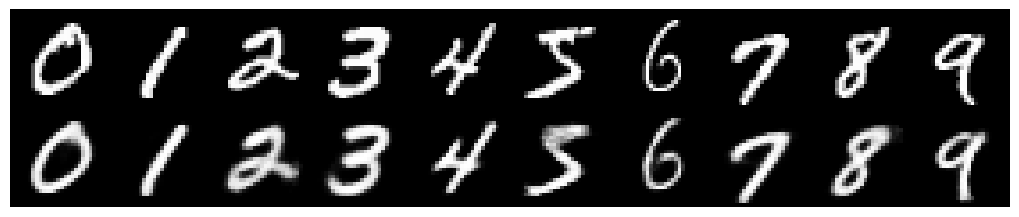

In [ ]:
wandb.agent(sweep_id, train, count=1)